In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import Table
import seaborn as sns
from toolbox import plot_tools
import scipy.stats
from toolbox.wololo import redshift2lumdistance, arcsectokpc
import astropy.units as u
from starlight_toolkit.dust import CAL
from matplotlib.patches import Ellipse

sns.set_style('ticks')
palette = sns.diverging_palette(220, 20, n=7)
halpha_palette = sns.light_palette('goldenrod',  5)
f275w_palette = sns.light_palette('mediumvioletred', 5)
f606w_palette = sns.light_palette('indigo', 5)

age_cmap = sns.diverging_palette(220, 20, as_cmap=True, sep=1)

mass_dict = {'JO201': 44194800000,
             'JO204': 54968402000,
             'JW100': 292875993000,
             'JW39': 164373004000,
             'JO175': 33957900300,
             'JO206': 77743301000
}

data_dir = 'C:\\Users\\ariel\\Workspace\\GASP\\HST\\Data\\'

halpha_input = Table.read(data_dir + 'halpha_bagpipes_input.fits')
f275w_input = Table.read(data_dir + 'f275w_bagpipes_input.fits')
f606w_input = Table.read(data_dir + 'f606w_bagpipes_input.fits')
optical_only_input = Table.read(data_dir + 'optical_only_bagpipes_input.fits')

output_halpha = Table.read(data_dir + 'halpha_dexp_logprior_single_bagpipes_results.fits')
output_f275w = Table.read(data_dir + 'f275w_dexp_logprior_single_bagpipes_results.fits')
output_f606w = Table.read(data_dir + 'f606w_dexp_logprior_single_bagpipes_results.fits')
output_optical_only = Table.read(data_dir + 'optical_only_dexp_logprior_single_bagpipes_results.fits')

halpha_input = halpha_input[(~halpha_input['disk']) & ((halpha_input['level'] == 0) | (halpha_input['leaf_flag'] == 1))]
f275w_input = f275w_input[(~f275w_input['disk']) & ((f275w_input['level'] == 0) | (f275w_input['leaf_flag'] ==1))]

flag_displacement = ~output_halpha['bad_double_fit'] & ~output_halpha['bad_fit'] & (halpha_input['parent_id'] != 'JO175_950_f606w')

halpha_input = halpha_input[flag_displacement]
output_halpha = output_halpha[flag_displacement]

flag_displacement_f275w = ~output_f275w['bad_double_fit'] & ~output_f275w['bad_fit'] & (f275w_input['parent_id'] != 'JO175_950_f606w')

f275w_input = f275w_input[flag_displacement_f275w]
output_f275w = output_f275w[flag_displacement_f275w]

f606w_input = f606w_input[~output_f606w['bad_fit']]
output_f606w = output_f606w[~output_f606w['bad_fit']]

output_halpha['galaxy'] = output_halpha['galaxy'].astype(str)
output_f275w['galaxy'] = output_f275w['galaxy'].astype(str)
output_f606w['galaxy'] = output_f606w['galaxy'].astype(str)

output_halpha['Location'] = np.zeros_like(output_halpha['galaxy'])
output_halpha['Location'][halpha_input['tail_gal_flag'] == 0] = np.full((halpha_input['tail_gal_flag'] == 0).sum(),
                                                                        'Tail')
output_halpha['Location'][halpha_input['tail_gal_flag'] == 1] = np.full((halpha_input['tail_gal_flag'] == 1).sum(),
                                                                        'Extraplanar')

output_f275w['Location'] = np.zeros_like(output_f275w['galaxy'])
output_f275w['Location'][f275w_input['tail_gal_flag'] == 0] = np.full((f275w_input['tail_gal_flag'] == 0).sum(),
                                                                      'Tail')
output_f275w['Location'][f275w_input['tail_gal_flag'] == 1] = np.full((f275w_input['tail_gal_flag'] == 1).sum(),
                                                                      'Extraplanar')

output_f606w['Location'] = np.zeros_like(output_f606w['galaxy'])
output_f606w['Location'][f606w_input['tail_gal_flag'] == 0] = np.full((f606w_input['tail_gal_flag'] == 0).sum(),
                                                                      'Tail')
output_f606w['Location'][f606w_input['tail_gal_flag'] == 1] = np.full((f606w_input['tail_gal_flag'] == 1).sum(),
                                                                      'Extraplanar')

output_halpha['galaxy_mass'] = np.zeros_like(output_halpha['mwage'])
for i in range(len(output_halpha)):
    output_halpha['galaxy_mass'][i] = np.log10(mass_dict[output_halpha['galaxy'][i]])

output_f275w['galaxy_mass'] = np.zeros_like(output_f275w['mwage'])
for i in range(len(output_f275w)):
    output_f275w['galaxy_mass'][i] = np.log10(mass_dict[output_f275w['galaxy'][i]])

output_f606w['galaxy_mass'] = np.zeros_like(output_f606w['mwage'])
for i in range(len(output_f606w)):
    output_f606w['galaxy_mass'][i] = np.log10(mass_dict[output_f606w['galaxy'][i]])

output_halpha['mwage'] *= 1e3
output_f275w['mwage'] *= 1e3
output_f606w['mwage'] *= 1e3
output_optical_only['mwage'] *= 1e3

output_halpha['age'] *= 1e3
output_f275w['age'] *= 1e3
output_f606w['age'] *= 1e3
output_optical_only['age'] *= 1e3

output_halpha['sfr'] = np.log10(output_halpha['sfr'])
output_f275w['sfr'] = np.log10(output_f275w['sfr'])
output_f606w['sfr'] = np.log10(output_f606w['sfr'])

output_halpha['Av'] = output_halpha['Av'] * output_halpha['eta']
output_f275w['Av'] = output_f275w['Av'] * output_f275w['eta']
output_f606w['Av'] = output_f606w['Av'] * output_f606w['eta']

conversion_factor = arcsectokpc(halpha_input['galaxy_redshift'])
halpha_input['area_exct'] = halpha_input['area_exact'] * conversion_factor ** 2

conversion_factor = arcsectokpc(f275w_input['galaxy_redshift'])
f275w_input['area_exct'] = f275w_input['area_exact'] * conversion_factor ** 2

conversion_factor = arcsectokpc(f606w_input['galaxy_redshift'])
f606w_input['area_exct'] = f606w_input['area_exact'] * conversion_factor ** 2

print(len(output_halpha), len(output_f275w), len(output_f606w))

print(np.min(output_f606w['stellar_mass']), np.max(output_f606w['stellar_mass']))
print(np.percentile(output_f606w['stellar_mass'], 5))

C:\Users\ariel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


342 841 296
3.895757757742637 7.153244136104432
4.183749741075106


C:\Users\ariel\AppData\Local\Temp\ipykernel_24812\4056682545.py:10: RuntimeWarning: divide by zero encountered in log10
  np.log10(1e3*output_halpha['parent_mwage'])[youngest]-np.log10(output_halpha['mwage'])[youngest],
C:\Users\ariel\AppData\Local\Temp\ipykernel_24812\4056682545.py:19: RuntimeWarning: divide by zero encountered in log10
  median_y_elongated = np.median(np.log10(1e3*output_halpha['parent_mwage'])[youngest & most_elongated]-np.log10(output_halpha['mwage'])[youngest & most_elongated])
C:\Users\ariel\AppData\Local\Temp\ipykernel_24812\4056682545.py:24: RuntimeWarning: divide by zero encountered in log10
  upper_y_elongated = np.percentile(np.log10(1e3*output_halpha['parent_mwage'])[youngest & most_elongated]-np.log10(output_halpha['mwage'])[youngest & most_elongated], 75)
C:\Users\ariel\AppData\Local\Temp\ipykernel_24812\4056682545.py:25: RuntimeWarning: divide by zero encountered in log10
  lower_y_elongated = np.percentile(np.log10(1e3*output_halpha['parent_mwage'])[you

[[1.       0.465143]
 [0.465143 1.      ]]
[[1.         0.37055405]
 [0.37055405 1.        ]]


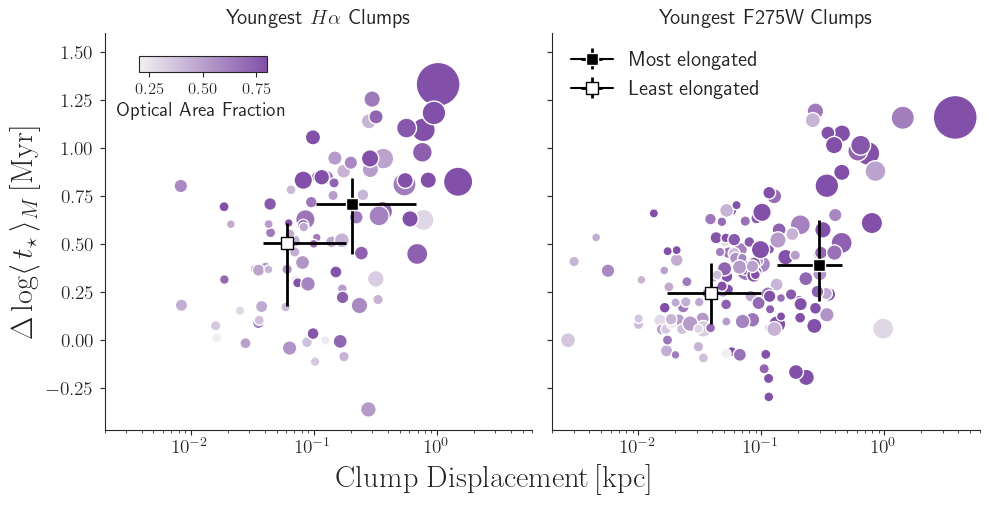

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

f606w_palette_long = sns.light_palette('indigo', 4)
cmap_f606w = sns.light_palette(f606w_palette_long[2], as_cmap=True)

matched_flag = halpha_input['quantities_match_flag'] & halpha_input['parent_resolved_flag'].astype(bool)
youngest = matched_flag & output_halpha['youngest_sibling']

mappable = ax[0].scatter(halpha_input['displacement_kpc_optical_only'][youngest],
                         np.log10(1e3*output_halpha['parent_mwage'])[youngest]-np.log10(output_halpha['mwage'])[youngest], 
                         c=halpha_input['parent_f_opt'][youngest], edgecolors='w', cmap=cmap_f606w,
                         s=1000*halpha_input['parent_radius'][youngest]/np.max(halpha_input['parent_radius'][youngest]),
                         vmin=0.2, vmax=0.8)

most_elongated = (halpha_input['parent_axial_ratio'] < np.percentile(halpha_input['parent_axial_ratio'][matched_flag], 20)) & matched_flag
least_elongated = (halpha_input['parent_axial_ratio'] > np.percentile(halpha_input['parent_axial_ratio'][matched_flag], 80)) & matched_flag

median_x_elongated = np.median(halpha_input['displacement_kpc_optical_only'][youngest & most_elongated])
median_y_elongated = np.median(np.log10(1e3*output_halpha['parent_mwage'])[youngest & most_elongated]-np.log10(output_halpha['mwage'])[youngest & most_elongated])

upper_x_elongated = np.percentile(halpha_input['displacement_kpc_optical_only'][youngest & most_elongated], 75)
lower_x_elongated = np.percentile(halpha_input['displacement_kpc_optical_only'][youngest & most_elongated], 25)

upper_y_elongated = np.percentile(np.log10(1e3*output_halpha['parent_mwage'])[youngest & most_elongated]-np.log10(output_halpha['mwage'])[youngest & most_elongated], 75)
lower_y_elongated = np.percentile(np.log10(1e3*output_halpha['parent_mwage'])[youngest & most_elongated]-np.log10(output_halpha['mwage'])[youngest & most_elongated], 25)

median_x_not_elongated = np.median(halpha_input['displacement_kpc_optical_only'][youngest & least_elongated])
median_y_not_elongated = np.median(np.log10(1e3*output_halpha['parent_mwage'])[youngest & least_elongated]-np.log10(output_halpha['mwage'])[youngest & least_elongated])

upper_x_not_elongated = np.percentile(halpha_input['displacement_kpc_optical_only'][youngest & least_elongated], 75)
lower_x_not_elongated = np.percentile(halpha_input['displacement_kpc_optical_only'][youngest & least_elongated], 25)

upper_y_not_elongated = np.percentile(np.log10(1e3*output_halpha['parent_mwage'])[youngest & least_elongated]-np.log10(output_halpha['mwage'])[youngest & least_elongated], 75)
lower_y_not_elongated = np.percentile(np.log10(1e3*output_halpha['parent_mwage'])[youngest & least_elongated]-np.log10(output_halpha['mwage'])[youngest & least_elongated], 25)


ax[0].errorbar(median_x_elongated, median_y_elongated, 
               xerr=[[median_x_elongated - lower_x_elongated], [upper_x_elongated - median_x_elongated]],
               yerr=[[median_y_elongated - lower_y_elongated], [upper_y_elongated - median_y_elongated]],
               marker='s', color='k', ms=8, markeredgewidth=1, 
               label='Most elongated complexes', markeredgecolor='w', capsize=0, elinewidth=2)
ax[0].errorbar(median_x_not_elongated, median_y_not_elongated, 
               xerr=[[median_x_not_elongated - lower_x_not_elongated], [upper_x_not_elongated - median_x_not_elongated]],
               yerr=[[median_y_not_elongated - lower_y_not_elongated], [upper_y_not_elongated - median_y_not_elongated]],
               marker='s', ecolor='k', ms=8, markeredgewidth=1, color='w', 
               markeredgecolor='k', label='Least elongated complexes', capsize=0, elinewidth=2)

print(np.corrcoef(np.log10(halpha_input['displacement_kpc_optical_only'][youngest]),
                  np.log10(1e3*output_halpha['parent_mwage'])[youngest]-np.log10(output_halpha['mwage'])[youngest]))

matched_flag = f275w_input['quantities_match_flag'] & f275w_input['parent_resolved_flag'].astype(bool)
youngest = matched_flag & output_f275w['youngest_sibling'] 

most_elongated = (f275w_input['parent_axial_ratio'] < np.percentile(f275w_input['parent_axial_ratio'][matched_flag], 20)) & matched_flag

ax[1].scatter(f275w_input['displacement_kpc_optical_only'][youngest],
              np.log10(1e3*output_f275w['parent_mwage'])[youngest]-np.log10(output_f275w['mwage'])[youngest],          
              c=f275w_input['parent_f_opt'][youngest], edgecolors='white', cmap=cmap_f606w,
              s=1000*f275w_input['parent_radius'][youngest]/np.max(f275w_input['parent_radius'][youngest]),
              vmin=0.2, vmax=0.8)


most_elongated = (f275w_input['parent_axial_ratio'] < np.percentile(f275w_input['parent_axial_ratio'][matched_flag], 20)) & matched_flag
least_elongated = (f275w_input['parent_axial_ratio'] > np.percentile(f275w_input['parent_axial_ratio'][matched_flag], 80)) & matched_flag

median_x_elongated = np.median(f275w_input['displacement_kpc_optical_only'][youngest & most_elongated])
median_y_elongated = np.median(np.log10(1e3*output_f275w['parent_mwage'])[youngest & most_elongated]-np.log10(output_f275w['mwage'])[youngest & most_elongated])

upper_x_elongated = np.percentile(f275w_input['displacement_kpc_optical_only'][youngest & most_elongated], 75)
lower_x_elongated = np.percentile(f275w_input['displacement_kpc_optical_only'][youngest & most_elongated], 25)

upper_y_elongated = np.percentile(np.log10(1e3*output_f275w['parent_mwage'])[youngest & most_elongated]-np.log10(output_f275w['mwage'])[youngest & most_elongated], 75)
lower_y_elongated = np.percentile(np.log10(1e3*output_f275w['parent_mwage'])[youngest & most_elongated]-np.log10(output_f275w['mwage'])[youngest & most_elongated], 25)

median_x_not_elongated = np.median(f275w_input['displacement_kpc_optical_only'][youngest & least_elongated])
median_y_not_elongated = np.median(np.log10(1e3*output_f275w['parent_mwage'])[youngest & least_elongated]-np.log10(output_f275w['mwage'])[youngest & least_elongated])

upper_x_not_elongated = np.percentile(f275w_input['displacement_kpc_optical_only'][youngest & least_elongated], 75)
lower_x_not_elongated = np.percentile(f275w_input['displacement_kpc_optical_only'][youngest & least_elongated], 25)

upper_y_not_elongated = np.percentile(np.log10(1e3*output_f275w['parent_mwage'])[youngest & least_elongated]-np.log10(output_f275w['mwage'])[youngest & least_elongated], 75)
lower_y_not_elongated = np.percentile(np.log10(1e3*output_f275w['parent_mwage'])[youngest & least_elongated]-np.log10(output_f275w['mwage'])[youngest & least_elongated], 25)

ax[1].errorbar(median_x_elongated, median_y_elongated, 
               xerr=[[median_x_elongated - lower_x_elongated], [upper_x_elongated - median_x_elongated]],
               yerr=[[median_y_elongated - lower_y_elongated], [upper_y_elongated - median_y_elongated]],
               marker='s', color='k', ms=8, markeredgewidth=1, label='Most elongated', 
               markeredgecolor='w', ecolor='k', capsize=0, elinewidth=2)
ax[1].errorbar(median_x_not_elongated, median_y_not_elongated, 
               xerr=[[median_x_not_elongated - lower_x_not_elongated], [upper_x_not_elongated - median_x_not_elongated]],
               yerr=[[median_y_not_elongated - lower_y_not_elongated], [upper_y_not_elongated - median_y_not_elongated]],
               marker='s', ecolor='k', ms=8, markeredgewidth=1, color='k', markerfacecolor='w', markeredgecolor='k', 
               label='Least elongated', capsize=0, elinewidth=2)


ax[1].legend(frameon=False, loc=2, fontsize=15)

print(np.corrcoef(np.log10(f275w_input['displacement_kpc_optical_only'][youngest]),
                  np.log10(1e3*output_f275w['parent_mwage'])[youngest]-np.log10(output_f275w['mwage'])[youngest]))

cb_ax = ax[0].inset_axes([0.08, 0.9, 0.3, 0.04])
cb = plt.colorbar(cax=cb_ax, orientation='horizontal', mappable=mappable)
cb.set_label(r'Optical Area Fraction', fontsize=14)
cb_ax.tick_params(labelsize=12)

ax[0].tick_params(axis='both', labelsize=14)
ax[1].tick_params(axis='both', labelsize=14)

fig.supxlabel(r'$\mathrm{Clump \; Displacement} \, \mathrm{[kpc]}$', fontsize=22)
ax[0].set_ylabel(r'$\Delta \log \langle\,t_\star\,\rangle_M\,\mathrm{[Myr]}$', fontsize=22)

fig.tight_layout()
fig.subplots_adjust(bottom=0.14, top=0.935)

ax[0].set_title(r'Youngest $H\alpha$ Clumps', fontsize=15)
ax[1].set_title(r'Youngest F275W Clumps', fontsize=15)

ax[0].set_ylim(-0.47, 1.6)
ax[1].set_xlim(0.002, 6)

plt.xscale('log')

sns.despine()

plt.savefig('age-displacement_horizontal.pdf')
plt.savefig('age-displacement_horizontal.jpg', dpi=300)

In [12]:
matched_flag = halpha_input['quantities_match_flag'] & halpha_input['parent_resolved_flag'].astype(bool)
youngest = matched_flag & output_halpha['youngest_sibling']
3.086e16*halpha_input['displacement_kpc_optical_only'][youngest]/3.154e7*1e6*(1e3*output_halpha['parent_mwage']-output_halpha['mwage'])[youngest]

2.1564788831099936e+16
4.615168303499977e+16
1.3392301830128712e+17
27378494373775.023
1.3119609011602822e+16
2.7366788327701066e+17
1886058180250911.0
-16962009505789.764
1.388849525803186e+16
3809778254465274.0
4124362530118840.5


In [15]:
output_halpha['mwage']

7.6867556737832
15.844175404134395
14.939736576410324
49.61486880386051
15.407771700096134
46.649047773489
6.482371015861867
21.37349149449855
16.131220067079862
10.08535485498824
13.355119828425032


0.46885335181712295 0.3525127851315296
0.4636591684818723 0.5537601626065617


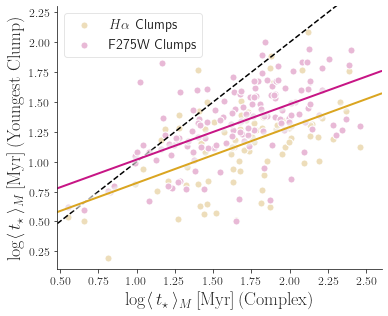

In [49]:
fig = plt.figure(figsize=(5.5, 4.5))

matched_flag = halpha_input['quantities_match_flag'] & halpha_input['parent_resolved_flag'].astype(bool)
youngest = matched_flag & output_halpha['youngest_sibling']

plt.scatter(np.log10(1e3*output_halpha['parent_mwage'][youngest]),
            np.log10(output_halpha['mwage'][youngest]), color=halpha_palette[1],
            label=r'$H\alpha$ Clumps', edgecolors='white', s=50)

# plt.errorbar(x=np.log10(1e3*output_halpha['parent_mwage'][youngest]),
#              y=np.log10(output_halpha['mwage'][youngest]), 
#              xerr=np.log10(1e3*output_halpha['parent_mwage_iqr'][youngest]),
#              yerr=np.log10(1e3*output_halpha['mwage_iqr'][youngest]),
#              fmt='none', color=halpha_palette[1])

correlation_halpha = scipy.stats.linregress(np.log10(1e3*output_halpha['parent_mwage'][youngest]),
                                            np.log10(output_halpha['mwage'][youngest]))
print(correlation_halpha.slope, correlation_halpha.intercept)
a_halpha, b_halpha = correlation_halpha.slope, correlation_halpha.intercept

matched_flag = f275w_input['quantities_match_flag'] & f275w_input['parent_resolved_flag'].astype(bool)
youngest = matched_flag & output_f275w['youngest_sibling'] 

plt.scatter(np.log10(1e3*output_f275w['parent_mwage'][youngest]),
            np.log10(output_f275w['mwage'][youngest]), color=f275w_palette[1],
            label=r'F275W Clumps', edgecolors='white', s=50)

correlation_f275w = scipy.stats.linregress(np.log10(1e3*output_f275w['parent_mwage'][youngest]),
                                            np.log10(output_f275w['mwage'][youngest]))
print(correlation_f275w.slope, correlation_f275w.intercept)
a_f275w, b_f275w = correlation_f275w.slope, correlation_f275w.intercept

x = np.linspace(0.4, 2.6)
y = x
plt.plot(x, y, '--k')

for lw in np.arange(4, 10, 0.25):
    plt.plot(x, a_halpha*x+b_halpha, color='w', lw=lw, alpha=0.05)
plt.plot(x, a_halpha*x+b_halpha, color=halpha_palette[4], lw=2)

for lw in np.arange(4, 10, 0.25):
    plt.plot(x, a_f275w*x+b_f275w, color='w', lw=lw, alpha=0.05)
plt.plot(x, a_f275w*x+b_f275w, color=f275w_palette[4], lw=2)

plt.xlim(0.48, 2.6)
plt.ylim(0.1, 2.3)

plt.legend(fontsize=14, framealpha=0.5, loc=2)

plt.xlabel(r'$\log \langle\,t_\star\,\rangle_M\,\mathrm{[Myr]} \, \mathrm{(Complex)}$', fontsize=18)
plt.ylabel(r'$\log \langle\,t_\star\,\rangle_M\,\mathrm{[Myr]} \, \mathrm{(Youngest\;Clump)}$', fontsize=18)

sns.despine()

plt.tick_params(axis='both', labelsize=12)

plt.tight_layout()

plt.savefig('complex-clump-age.pdf')
plt.savefig('complex-clump-age_presentations.jpg', dpi=300)

In [53]:
test = halpha_input['dist_kpc']-halpha_input['parent_distance']

In [19]:
np.mean(output_halpha['mwage'][halpha_input['parent_resolved_flag'].astype(bool)][test<0.1])

21.28229744886012

In [72]:
displacement_flag = (halpha_input['displacement_kpc'] > 0.5)
distance_difference = (halpha_input['dist_kpc']-halpha_input['parent_distance'])/halpha_input['parent_distance']
matched_flag = halpha_input['quantities_match_flag'] & halpha_input['parent_resolved_flag'].astype(bool) & (output_halpha['parent_mwage']>0)

<ipython-input-72-bb87137d5d4f>:2: RuntimeWarning: divide by zero encountered in divide
  distance_difference = (halpha_input['dist_kpc']-halpha_input['parent_distance'])/halpha_input['parent_distance']


<ipython-input-76-84edc06d453f>:1: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(1e3*output_halpha['parent_mwage'])[matched_flag & (distance_difference>0.1)]-np.log10(output_halpha['mwage'])[matched_flag & (distance_difference>0.1)], density=True, histtype='step')
<ipython-input-76-84edc06d453f>:2: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(1e3*output_halpha['parent_mwage'])[matched_flag & (distance_difference<0)]-np.log10(output_halpha['mwage'])[matched_flag & (distance_difference<0)], density=True, histtype='step')


(array([0.10647871, 0.        , 0.10647871, 0.21295742, 0.53239356,
        0.63887227, 1.27774454, 0.74535098, 0.63887227, 0.53239356]),
 array([-0.88457079, -0.67586971, -0.46716863, -0.25846754, -0.04976646,
         0.15893462,  0.3676357 ,  0.57633678,  0.78503786,  0.99373895,
         1.20244003]),
 [<matplotlib.patches.Polygon at 0x7fc39c700c10>])

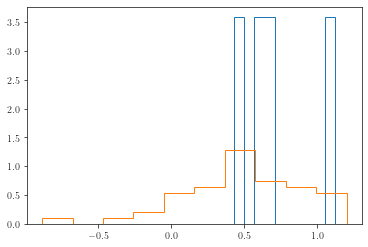

In [76]:
plt.hist(np.log10(1e3*output_halpha['parent_mwage'])[matched_flag & (distance_difference>0.1)]-np.log10(output_halpha['mwage'])[matched_flag & (distance_difference>0.1)], density=True, histtype='step')
plt.hist(np.log10(1e3*output_halpha['parent_mwage'])[matched_flag & (distance_difference<0)]-np.log10(output_halpha['mwage'])[matched_flag & (distance_difference<0)], density=True, histtype='step')

<ipython-input-73-8ddab8e39bbc>:2: RuntimeWarning: divide by zero encountered in log10
  np.log10(1e3*output_halpha['parent_mwage'])[matched_flag]


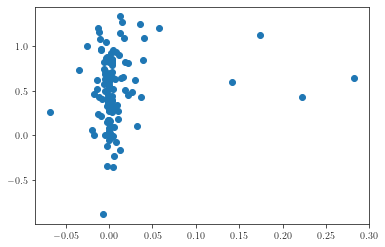

In [73]:
plt.scatter(distance_difference[matched_flag], 
            np.log10(1e3*output_halpha['parent_mwage'])[matched_flag]
            -np.log10(output_halpha['mwage'])[matched_flag])

In [85]:
(distance_difference[matched_flag]<-0.01).sum()

13